In [ ]:
## Overview 

# INPUT: data that has been preprocessed (i.e. wavelet extracted and averaged) to run partial correlation and regular spearman correlation 
# INPUT: .csv files saved in jsaal folder (now copied over to /userdata/aallawala/pain_data/stage0/redcap) 
# not structured yet to run as python script bc still working on adding other analysis. 

#For Hazel: the variables to work with for logistic regression are: 
# Issues that we typically run into that would be good to fix: 
# 
# 1. some trials are missing for surveys (i.e. nan values for pain scores but not for mood scores or the other way around
# -- we should keep all the data we can unless we're doing a 1-1 comparison like for pairwise t-stats)
# 2. some channels are missing across days, so we need a way to handle this. might be easier to talk about this over zoom 


# X = clean_psd_z.T trials x number_frequencies x number_channels (e.g. 200 x 40 x 150)
# Y = vasd_z_clean_r number_trials 
# Z = vasp_z_clean 
# (you'll find these later down in this script)



In [1]:
%reset
import sys
sys.path.append("/home/jiahuang/test-code-hazel/")
import gen_fxns
import h5py
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import scipy as sp
from datetime import date
import pandas as pd 
from datetime import timedelta
from scipy.stats import zscore
import seaborn as sns 
import pickle 
import os 

In [2]:
ptID = "RCS02" # patient ID
path_string = f"/userdata/jiahuang/pain-data/Stage1-test/{ptID}/biomarker/preproc_data/all_channels/"
pt_path = "/userdata/rvatsyayan/AnushaData/HDF5 Pain Data/RCS02"
data_root = Path(path_string)
file_keyword = '_meanpsd'
dataset_name = "mean_psd" # files with mean power spectral density 

# Function to extract numeric part from filename
def extract_number(filename):
    return int(''.join(filter(str.isdigit, filename)))

def load_h5_files(path_string, pt_path, file_keyword, dataset_name):
    import re
    h5_arrays = []
    fileids = [] 
    # Get list of files in directory and sort them based on numeric part
    files = sorted(os.listdir(path_string), key=extract_number)
    
    for filename in files:
        if filename.endswith('.h5') and file_keyword in filename:
            # Construct the full file path
            filepath = os.path.join(path_string, filename)
            print(filepath)
            # Load the .h5 file
            with h5py.File(filepath, 'r') as hf:
                # Assuming you want to load the first dataset from each file
                # Load the dataset as float32
                dataset = np.array(hf[dataset_name], dtype=np.float32)
                # Append the dataset to the list
                h5_arrays.append(dataset)

    files = sorted(os.listdir(pt_path), key=extract_number)
    for filename in files:
        with h5py.File(os.path.join(pt_path, filename), 'r') as hf:
            # get record_id 
            fileid = int(pd.DataFrame(hf['pain_info']).iloc[0,0])
            fileids.append(fileid)
    print(fileids)

    return h5_arrays, fileids



# try:
#     loaded_datasets = load_h5_files(directory_path, keyword, dataset_name)
#     # Now you can work with loaded_datasets
# except FileNotFoundError:
#     print(f"Directory '{directory_path}' not found.")

h5_arrays,fileids = load_h5_files(path_string, pt_path, file_keyword, dataset_name)



/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/all_channels/1_meanpsd.h5
/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/all_channels/2_meanpsd.h5
/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/all_channels/3_meanpsd.h5
/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/all_channels/4_meanpsd.h5
/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/all_channels/5_meanpsd.h5
/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/all_channels/6_meanpsd.h5
/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/all_channels/7_meanpsd.h5
/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/all_channels/8_meanpsd.h5
/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/all_channels/9_meanpsd.h5
/userdata/jiahuang/pain-data/Stage1-test/RCS02/biomarker/preproc_data/all_channels/10_meanpsd.h5
/userdata/jiahuang/pain-data/Stage1-tes

In [4]:

# concatenate data and zscore 
all_data  = []
all_data = np.stack(h5_arrays, axis=2)
print("freqs x channels x trials:", all_data.shape) 
del h5_arrays
from scipy.stats import zscore
psd_z = zscore(all_data,axis = 2) #freqs x channels x trials: e.g. (40, 124, 241)



freqs x channels x trials: (48, 148, 118)


In [5]:
file = f"/userdata/rvatsyayan/AnushaData/Pain_Scores_{ptID}.xlsx"
raw_surveys = pd.read_excel(file)
print(raw_surveys.shape) # e.g.  (225, 22)
n_trials = raw_surveys.shape[0]
raw_surveys

(225, 22)


,record_id,Timestamp,nrs_s0,intensity_vas_s0,mood_vas_s0,unpleasantness_vas_s0,relief_s0,throbbing_s0,shooting_s0,stabbing_s0,...,gnawing_s0,hot_burning_s0,aching_s0,heavy_s0,tender_s0,splitting_s0,tiring_exhausting_s0,sickening_s0,fearful_s0,punishing_cruel_s0
0,42,2020-07-29 11:18:21,NaN,52,54.0,53.0,NaN,2.0,3.0,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0
1,44,2020-07-29 11:56:31,NaN,47,56.0,50.0,NaN,1.0,2.0,1.0,...,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0
2,45,2020-07-29 13:07:17,NaN,50,53.0,53.0,NaN,1.0,2.0,2.0,...,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0
3,47,2020-07-29 14:02:36,NaN,54,52.0,50.0,NaN,1.0,1.0,2.0,...,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
4,50,2020-07-29 14:51:10,NaN,51,50.0,50.0,NaN,2.0,2.0,2.0,...,1.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,328,2020-08-06 19:26:02,4.0,57,64.0,94.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
221,329,2020-08-07 07:55:26,5.0,80,72.0,74.0,NaN,NaN,NaN,2.0,...,NaN,NaN,3.0,NaN,3.0,3.0,NaN,NaN,NaN,1.0
222,330,2020-08-07 09:08:38,2.0,23,66.0,34.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,331,2020-08-07 09:54:46,1.0,36,65.0,33.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN


In [6]:
# clean up data 

missing_bm_data = np.setdiff1d(raw_surveys.record_id, fileids) # Return the unique values in ar1 that are not in # unique vals in survey ids that dont have neural data files.

missing_surveys = np.setdiff1d( fileids, raw_surveys.record_id) # unique vals in neuraldata file ids that dont exist in survey data. 

missing_channels = [i for i in range(all_data.shape[1]) if np.any(all_data[:,i,:])!=0]
print((missing_channels))

# remove missing survey record ids from neural data. 
idx_missing_surveys = ~np.isin(fileids, missing_surveys)

new_alldata = psd_z[:,:,idx_missing_surveys]
new_alldata = new_alldata[:,missing_channels,:]
print(new_alldata.shape)

idx_missing_neuraldata = ~np.isin(raw_surveys.record_id, missing_bm_data)
new_surveys = raw_surveys.iloc[idx_missing_neuraldata]
print(new_surveys.shape)

assert(new_surveys.shape[0] == new_alldata.shape[2])

# Create a new list with only the elements where the boolean mask is True
filtered_list = [item for item, keep in zip(fileids, idx_missing_surveys) if keep]
print(filtered_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
(48, 115, 118)
(118, 22)
[42, 44, 45, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 66, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 92, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 167, 170, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,

In [7]:
remaining_diff = np.setdiff1d( new_surveys.record_id, filtered_list)
if len(remaining_diff) == 0:
    print('continue')
elif len(remaining_diff) >0:
    print('Error')

print(new_surveys.shape)
print(len(filtered_list))

continue
(118, 22)
118


In [8]:
## reshape and zscore surveys. 
# psd_z_vec = new_alldata.reshape(new_alldata.shape[2], -1)
n_freq = new_alldata.shape[0]
n_ch = new_alldata.shape[1]
n_feats = n_freq * n_ch  # num of neural features
n_trials = new_alldata.shape[2]
psd_z_vec = np.reshape(new_alldata, (n_feats, n_trials))

vasd = new_surveys['mood_vas_s0'].to_numpy() # depression/mood survey scores 
vasp = new_surveys['intensity_vas_s0'].to_numpy() #pain survey scores

vasd_vec = vasd.reshape(-1)
vasp_vec = vasp.reshape(-1)

def man_z_score(array):
    array_mean = np.nanmean(array)
    array_std = np.nanstd(array)
    zscore_array = (array - array_mean)/array_std
    return zscore_array

vasd_z = man_z_score(vasd_vec)
vasp_z = man_z_score(vasp_vec)

In [9]:
## remove nans from filtered data.  

def find_nans(array):
    # if nan_idx.any():
    nan_idx = np.argwhere(np.isnan(array))
    if nan_idx.any():
        print("The array contains NaN values.")
    else:
        print("The array does not contain any NaN values.") 
    return nan_idx

nan_idx_vasd = find_nans(vasd_z)
nan_idx_vasp = find_nans(vasp_z)
nan_idx_all  = np.unique([nan_idx_vasd, nan_idx_vasp])
print(nan_idx_all)
# clean up surveys from nans. 
vasd_z_clean = np.delete(vasd_z, [nan_idx_all], axis = 0)
vasp_z_clean = np.delete(vasp_z, [nan_idx_all], axis = 0)

# remove nans. 
new_surveys = new_surveys.drop(new_surveys.index[nan_idx_all], axis=0) # remove by positional index clean_psd_z= np.delete(psd_z_vec, nan_idx_all, axis=1)
clean_psd_z= np.delete(psd_z_vec, nan_idx_all, axis=1) #**** ?????
print(clean_psd_z.shape)


The array does not contain any NaN values.
The array does not contain any NaN values.
[]
(5520, 118)


In [10]:
# flip depression scores (so that worse mood = higher mood score, to match worse pain = higher pain score)

# Reverse the scores
max_score = max(vasd_z_clean)
min_score = min(vasd_z_clean)

# Reverse the depression scores such that higher original scores correspond to lower new scores
vasd_z_clean_r = max_score + min_score - vasd_z_clean


In [12]:
# Dimension reduction of all_data
band_data = np.zeros((6, n_ch, n_trials))
bandref = {'delta':(1,4), 'theta':(5,8), 'alpha':(9,12), 'beta':(13,30), 'low gamma':(31,70), 'high gamma':(71,150)}
bands = list(bandref.keys())
clean_alldata = all_data[:,:,idx_missing_surveys]
clean_alldata = clean_alldata[:,missing_channels,:]
print(clean_alldata.shape)

import re
ch_labels = []
freqs = []
with h5py.File(f"{path_string}/1_meanpsd.h5", 'r') as hf:
    for i in missing_channels:
        ch = re.findall(r"\d+([A-Z]+\d+)",str(hf.attrs['ch_labels'][i]))[0]
        ch_labels.append(ch)
    freqs = hf.attrs['freqs']
canonical_freq = [bandref[bands[i]][0] for i in range(len(bands))]


for b in range(len(bands)):
    band = bands[b]
    (fmin, fmax) = bandref[band]
    idxf = np.where((freqs >= fmin) & (freqs <= fmax))[0]
    band_data[b, :, :] = np.mean(clean_alldata[idxf, :, :], axis=0)

large_ROI = np.unique([re.findall(r"[A-Z]+", s)[0] for s in ch_labels])
ch_data = np.zeros((len(bands), len(large_ROI), n_trials))

for i in range(len(large_ROI)):
	ch = large_ROI[i]
	idxc = [ch in ch_name for ch_name in ch_labels]
	ch_data[:,i,:] = np.mean(band_data[:, idxc, :], axis = 1)
	
all_data_clean_freq_band = zscore(ch_data, axis = 2)
all_data_clean_freq_band_z = all_data_clean_freq_band.reshape(len(bands)*len(large_ROI), n_trials).T

print(ch_labels)
print(large_ROI)
print(freqs)
print(canonical_freq)

(48, 115, 118)
['RSGC1', 'RSGC2', 'RSGC3', 'RSGC4', 'RSGC7', 'RSGC8', 'RSGC9', 'RSGC10', 'RSGC11', 'RSGC12', 'RSGC13', 'RSGC14', 'RSGC15', 'LSGC1', 'LSGC2', 'LSGC3', 'LSGC4', 'LSGC5', 'LSGC6', 'LSGC7', 'LSGC8', 'LSGC9', 'LSGC10', 'LSGC11', 'LSGC12', 'LSGC13', 'LSGC14', 'LSGC15', 'RACC1', 'RACC2', 'RACC3', 'RACC4', 'RACC5', 'RACC6', 'RACC7', 'RACC8', 'RACC9', 'LACC1', 'LACC2', 'LACC3', 'LACC4', 'LACC5', 'LACC6', 'LACC7', 'LACC8', 'LACC9', 'RVPN1', 'RVPN2', 'RVPN3', 'RVPN4', 'RVPN5', 'RVPN6', 'RVPN7', 'RVPN8', 'RVPN15', 'RM1', 'RM2', 'RM3', 'RM4', 'RM5', 'RM6', 'RM7', 'RM8', 'RM9', 'RM10', 'RM11', 'RM12', 'RM13', 'RM14', 'RM15', 'LAI1', 'LAI2', 'LAI3', 'LAI4', 'LAI5', 'LAI6', 'LAI7', 'LAI8', 'LAI9', 'LAI10', 'LAI11', 'LAI12', 'LAI13', 'LAI14', 'LAI15', 'LPI1', 'LPI2', 'LPI3', 'LPI4', 'LPI5', 'LPI6', 'LPI7', 'LPI8', 'LPI9', 'LPI10', 'LPI11', 'LPI12', 'LPI13', 'LPI14', 'LPI15', 'LVC1', 'LVC2', 'LVC3', 'LVC4', 'LVC5', 'LVC6', 'LVC7', 'LVC8', 'LVC9', 'LVC10', 'LVC11', 'LVC12', 'LVC13', 'LVC1

In [13]:
import statsmodels.api as sm
from patsy import dmatrices

df = pd.DataFrame({'VASP': vasp_z_clean.flatten(), 'VASD': vasd_z_clean_r.flatten()})
clean_psd_z_new = clean_psd_z.T

for i in range(clean_psd_z_new.shape[1]):
    df[f'PSD{i}'] = clean_psd_z_new[:, i]

design_matrices = {}

for i in range(clean_psd_z_new.shape[1]):
    formula = f'PSD{i} ~ VASD + VASP'
    y, X = dmatrices(formula, data=df, return_type='dataframe')
    design_matrices[f'PSD{i}'] = {'y': y, 'X': X}

results = {}

for key in design_matrices.keys(): #keys are psd0, psd1, etc. 
    y = design_matrices[key]['y']
    X = design_matrices[key]['X']
    
    mod = sm.OLS(y, X)  # Create model
    res = mod.fit()     # Fit model
    
    results[key] = {
        'summary': res.summary(),  # Summary of the regression
        'tvalues': res.tvalues,    # T-values of the coefficients
        'pvalues': res.pvalues     # P-values of the coefficients
    }

#put t-values in an array. 
t_vals= [] 
p_vals =[] 
for i in range(len(results)):
    tmp_tval = results[f'PSD{i}']['tvalues']['Intercept']
    t_vals.append(tmp_tval)

    tmp_pval = results[f'PSD{i}']['pvalues']['Intercept']
    p_vals.append(tmp_tval)

tval_stack = np.vstack(t_vals)
tval_reshape = np.reshape(tval_stack,[n_freq, n_ch])

pval_stack = np.vstack(p_vals)
pval_reshape = np.reshape(pval_stack,[n_freq, n_ch])

/tmp/ipykernel_2586594/3450355643.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'PSD{i}'] = clean_psd_z_new[:, i]
/tmp/ipykernel_2586594/3450355643.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'PSD{i}'] = clean_psd_z_new[:, i]
/tmp/ipykernel_2586594/3450355643.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

In [14]:
def run_corr(x,y, n_freq, n_ch):
    from scipy.stats import spearmanr
    corr,p_value = spearmanr(x,y)
    correlations = corr[:-1,-1]
    new_corr = correlations.reshape(n_freq,n_ch)
    return new_corr

corr_vasd = run_corr(clean_psd_z.T, vasd_z_clean_r, n_freq, n_ch)
corr_vasd2 = run_corr(all_data_clean_freq_band_z, vasd_z_clean_r, len(bands), len(large_ROI))
# corr_vasd = run_corr(clean_psd_z.T, vasd_z_clean, n_freq, n_ch)

corr_vasp = run_corr(clean_psd_z.T, vasp_z_clean, n_freq, n_ch)
corr_vasp2 = run_corr(all_data_clean_freq_band_z, vasp_z_clean, len(bands), len(large_ROI))


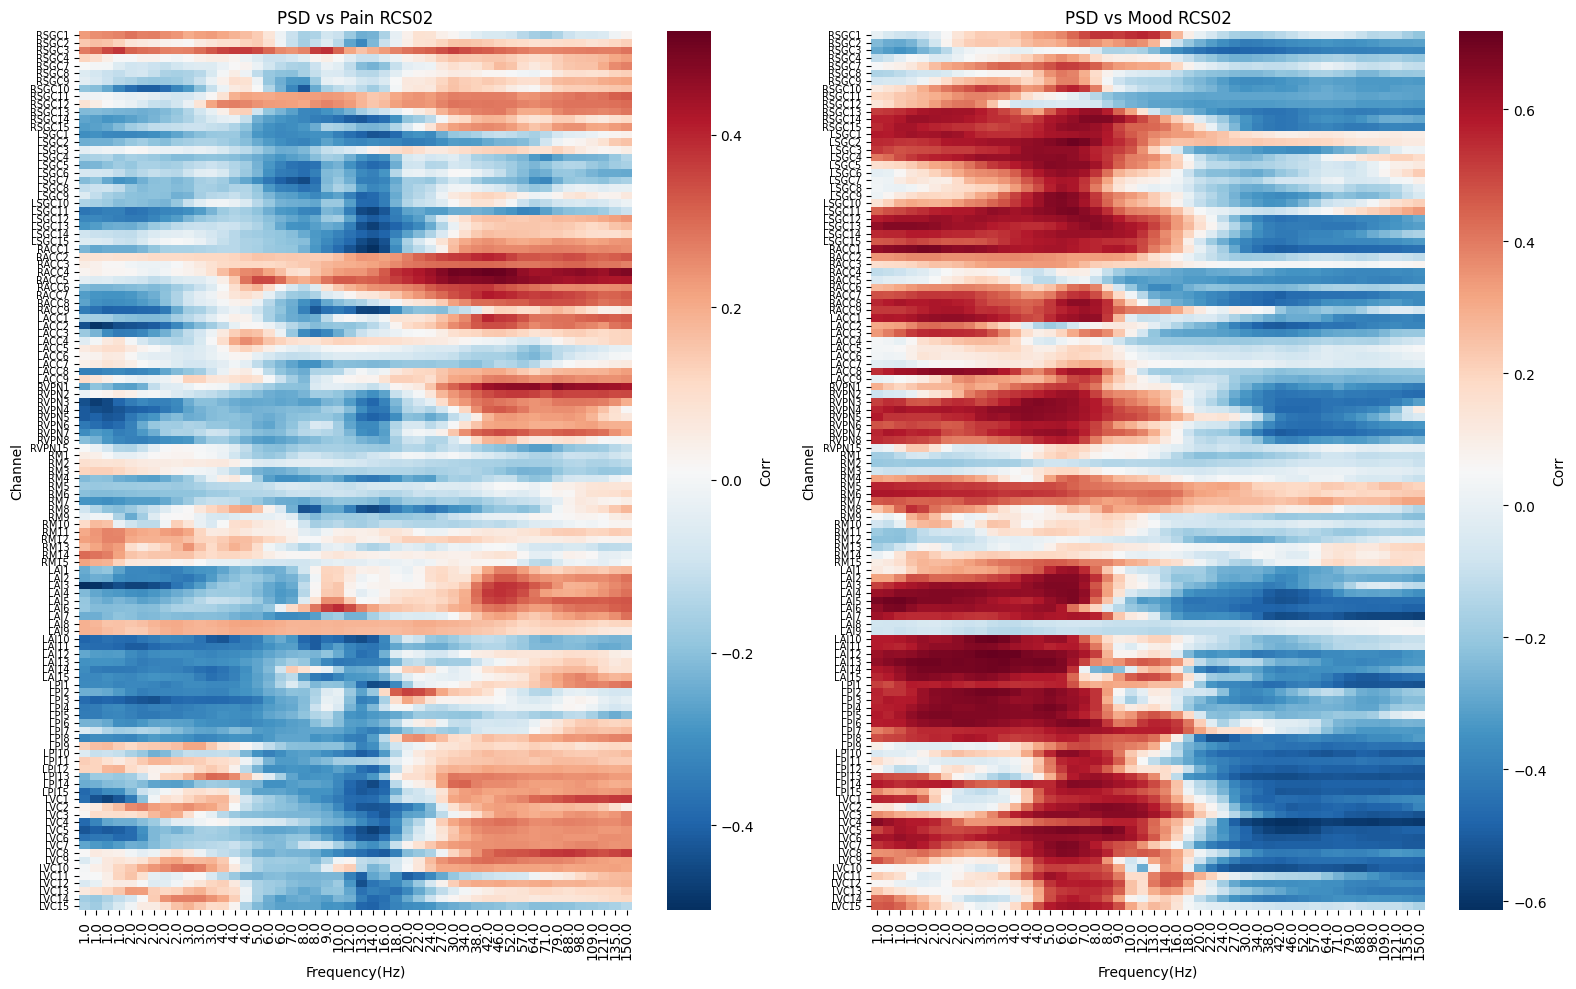

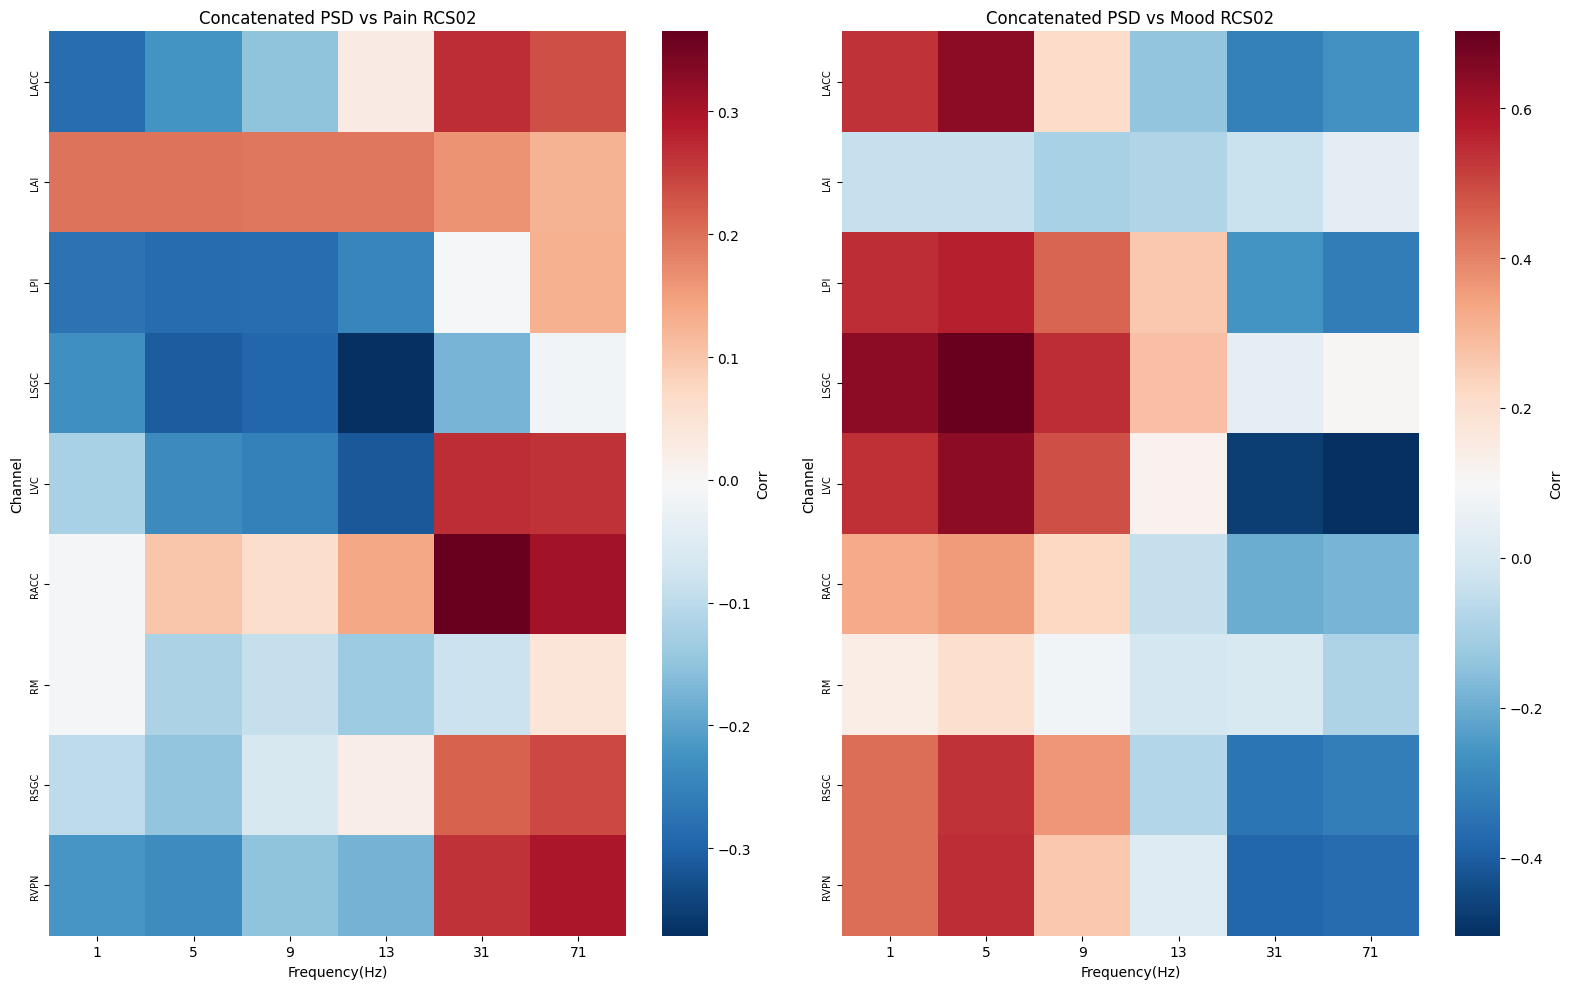

In [169]:
sys.path.append("/home/jiahuang/test-code-hazel/gen_fxns/")
savepath = f"/userdata/jiahuang/pain-data/figures/Stage1-test/{ptID}/"
import os
os.makedirs(savepath, exist_ok=True)

def basic_heatmap(ax, array, ch_labels, freqs, cbar_title, title):
    fig_params = [8, 12]
    caxis_lim = [-0.1, 0.2]
    
    sns.heatmap((array.T), cmap="RdBu_r", cbar=True, 
                yticklabels=ch_labels, xticklabels=np.round(freqs), 
                cbar_kws={'label': cbar_title}, ax=ax)
    ax.set_xlabel("Frequency(Hz)")
    ax.set_ylabel("Channel")
    ax.set_title(title)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)


def plot_heatmap_subplots(data_list, ch_labels, freqs, cbar_titles, titles, savetitle, nrows, ncols):
    """
    Generate subplots using the custom heatmap function.

    Parameters:
    data_list (list of ndarray): List of 2D arrays to be plotted as heatmaps.
    cbar_titles (list of str): List of colorbar titles for each heatmap.
    titles (list of str): List of titles for each heatmap.
    nrows (int): Number of rows in the subplot grid.
    ncols (int): Number of columns in the subplot grid.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 10 * nrows))
    axes = axes.flatten() 

    for i, (array, cbar_title, title) in enumerate(zip(data_list, cbar_titles, titles)):
        basic_heatmap(axes[i], array, ch_labels, freqs, cbar_title, title)

    plt.tight_layout()
    save_dir = f"/userdata/jiahuang/pain-data/figures/Stage1-test/{ptID}/{savetitle}"

    plt.savefig(save_dir, dpi=300, edgecolor='k', facecolor="white")
    plt.show()


# Plot the heatmaps in a 2x2 grid
plot_heatmap_subplots([corr_vasp, corr_vasd], ch_labels, freqs, ['Corr', 'Corr'], ['PSD vs Pain %s' % (ptID), 'PSD vs Mood %s' % (ptID)], "All chanel roi correlation", nrows=1, ncols=2)

plot_heatmap_subplots([corr_vasp2, corr_vasd2], large_ROI, canonical_freq, ['Corr', 'Corr'], ['Concatenated PSD vs Pain %s' % (ptID), 'Concatenated PSD vs Mood %s' % (ptID)], "Canonical chanel roi correlation ", nrows=1, ncols=2)


In [16]:
mask_pvalues = pval_reshape > 0.05
# Apply mask: Set values where mask is True to NaN
masked_t_vals = np.where(mask_pvalues, np.nan, tval_reshape)

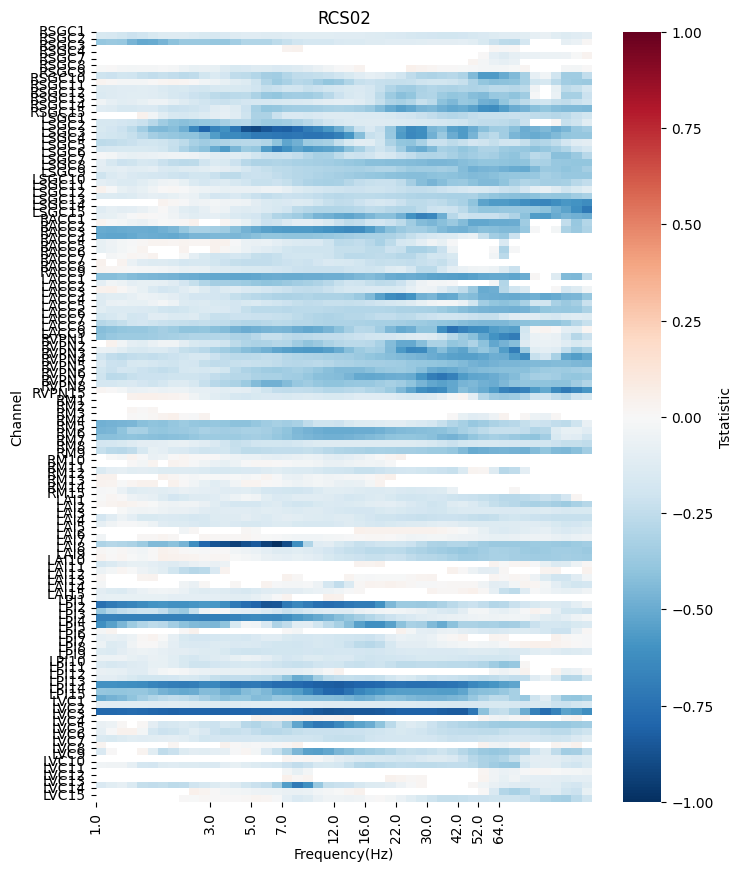

In [30]:
# Didn't change here - y_ticks?
fig, ax = plt.subplots(figsize=[8,10])
sns.heatmap((masked_t_vals.T), cmap='RdBu_r', cbar=True, 
 vmin = -1, vmax = 1, yticklabels=ch_labels, xticklabels=np.round(freqs), cbar_kws={'label': 'Tstatistic'})

ytick_labels = ch_labels
if ptID=="RCS05":
    y_ticks = [0,8,21,32, 40, 50, 58, 71, 84, 91]
elif ptID=="RCS04":
    y_ticks = [0,8,15,26,31,41,47,54,65, 66]
elif ptID == "RCS02":
    y_ticks = [0,9,24, 40, 55,70,79,91,99]
elif ptID == "RCS07":
    y_ticks = [0,10,23,37,49,60,67,76,83,94,100,107]

y_ticks = np.arange(0,115,1)
ytick_labels = ch_labels
x_ticks = [0, 11, 15, 18, 23, 26, 29, 32, 35, 37, 39]
xtick_labels = freqs[x_ticks]  # Use the correct subset of ylabels
ax.set(xticks = x_ticks, xticklabels = np.round(xtick_labels), yticks = y_ticks, yticklabels = ytick_labels)
plt.title(f"{ptID}")
ax.set_xlabel("Frequency(Hz)")
ax.set_ylabel("Channel")

# savepath = f"/userdata/jiahuang/pain_data/figures/mult_lin_reg/{ptID}_intercept_linearreg.png"
# plt.savefig(savepath, dpi = 300, edgecolor = 'k', facecolor="white")
plt.show()



In [46]:
from scipy import stats, linalg

# Step 1: Fit regression models and obtain residuals
# Regression of Y on Z
n_feats = len(ch_labels)*len(freqs)
X = clean_psd_z.T
Yd = vasd_z_clean_r
Yp = vasp_z_clean

slope_YY, intercept_YY, _, _, _ = stats.linregress(Yd, Yp)
Yp_pred = slope_YY * Yd + intercept_YY
Y_resid = Yp - Yp_pred

# Regression of each feature in X on Z
X_resid = np.zeros_like(X)
for i in range(n_feats):
    slope_XZ, intercept_XZ, _, _, _ = stats.linregress(Yd, X[:, i])
    X_pred = slope_XZ * Yd + intercept_XZ
    X_resid[:, i] = X[:, i] - X_pred

# Step 2: Compute partial correlation coefficients
partial_corr_XY_Z_reg = np.zeros(n_feats)
partial_corr_XY_Z_reg_p = np.zeros(n_feats)
for i in range(n_feats):
    partial_corr_XY_Z_reg[i], partial_corr_XY_Z_reg_p[i] = stats.pearsonr(X_resid[:, i], Y_resid)
mask = partial_corr_XY_Z_reg_p>0.05
# print("Partial correlation coefficients between X and Y controlling for Z using regression: ")
pcorr_reshaped = partial_corr_XY_Z_reg.reshape(len(freqs), len(ch_labels))

print("Partial correlation coefficients between X and Y controlling for Z using regression:")
pcorr = pd.DataFrame(pcorr_reshaped, index=freqs, columns=ch_labels)
# pcorr

Partial correlation coefficients between X and Y controlling for Z using regression:


TypeError: only integer scalar arrays can be converted to a scalar index

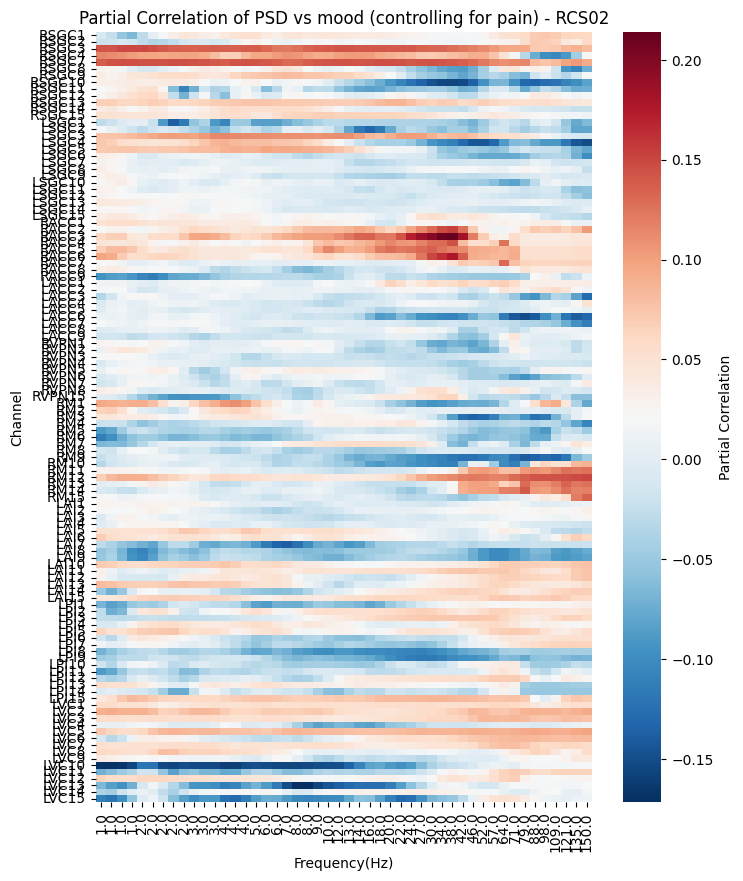

In [47]:
# save_dir = '/userdata/aallawala/pain_data/figures/mult_lin_reg/%s_Partial_corr_mood_masked.png' % (ptID)
fig, ax = plt.subplots(figsize=[8,10])
ax = sns.heatmap((pcorr_reshaped.T), cmap="RdBu_r", cbar=True, 
    yticklabels=ch_labels, xticklabels=np.round(freqs), cbar_kws={'label': 'Partial Correlation'})
yticklabels='auto'
plt.xlabel("Frequency(Hz)")
plt.ylabel("Channel")
plt.title('Partial Correlation of PSD vs mood (controlling for pain) - %s' % (ptID))
# xticklabels = 'auto'
ytick_labels = ch_labels
if ptID=="RCS05":
    y_ticks = [0,8,21,32, 40, 50, 58, 71, 84, 91]
elif ptID=="RCS04":
    y_ticks = [0,8,15,26,31,41,47,54,65, 66]
elif ptID == "RCS02":
    y_ticks = [0,9,24, 40, 55,70,79,91,99]
elif ptID == "RCS07":
    print('get it')

y_ticks = np.arange(0,115,1)
ytick_labels = ytick_labels[y_ticks]
x_ticks = [0, 11, 15, 18, 23, 26, 29, 32, 35, 37, 39]
xtick_labels = freqs[x_ticks]  # Use the correct subset of ylabels
ax.set(xticks = x_ticks, xticklabels = np.round(xtick_labels), yticks = y_ticks, yticklabels = ytick_labels)
plt.tight_layout()
# plt.savefig(save_dir, dpi=300, edgecolor='k', facecolor="white")

plt.show()


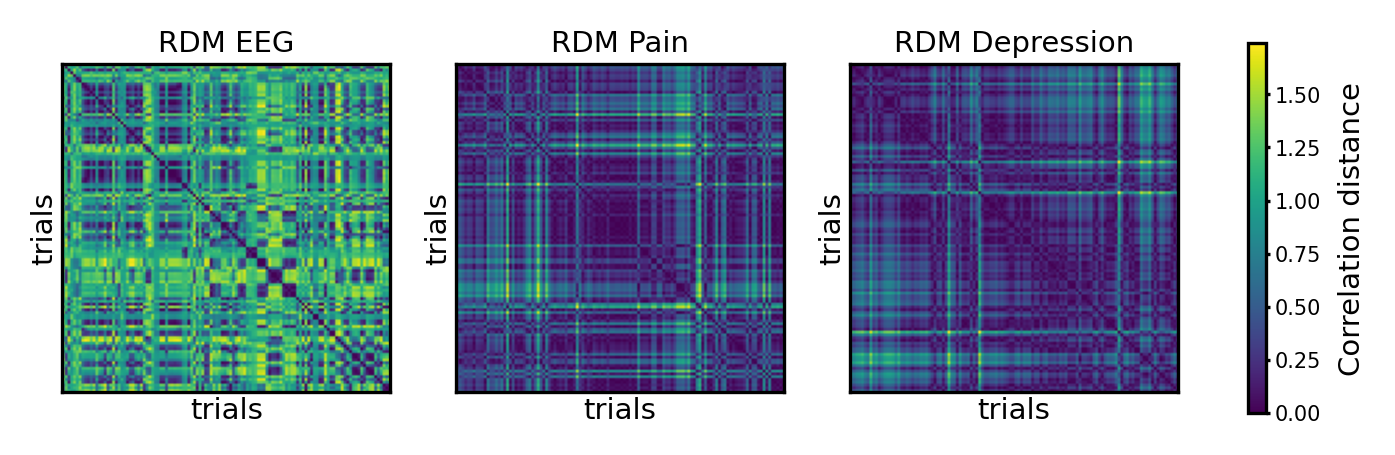

0.19668851617758348 -0.02972587894554772 0.07427414892703353
3.657325625929568e-61 0.013516889585158901 6.474110101738673e-10


In [179]:
# Add Representation Similarity Analysis here
# Input:
#   X = clean_psd_z (trials x number_frequencies x number_channels, 211*40*124)
#   Yd = vasd_z_clean_r (number_trials)
#   Yp = vasp_z_clean 

# Calculate RDM:
#    RDMeeg[i, j] = 1 - pearsoncorr(X[i,:,:], X[j,:,:])
#    RDMpain[i, j] = Euclidean(Yd[i],Yd[j])

# Upper triangle:
#    eeg_vec = upper(RDMeeg)
#    pain_vec = upper(RDMpain)

# Compute RSA:
#    rsa = SpearmanCorr(eeg_vec, pain_vec)

from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

def upper_triangular(df):
    idx = np.triu_indices_from(df, k=1)
    return df[idx]

RDMpain = squareform(pdist(vasp_z_clean.reshape(-1,1), metric = 'euclidean'))
RDMdep = squareform(pdist(vasd_z_clean_r.reshape(-1,1), metric = 'euclidean'))

# raw score of vas is 0-100, zscore is -1 to 1
RDMf = squareform(pdist(all_data_clean_freq_band_z, metric='correlation'))

# dissimilarity 1-correlation

pain_vec = upper_triangular(RDMpain)
dep_vec = upper_triangular(RDMdep)
f_vec = upper_triangular(RDMf)

corr_freqvd, p_value_freqvd = spearmanr(f_vec, dep_vec)
corr_freqvp, p_value_freqvp = spearmanr(f_vec, pain_vec)
corr_dvp, p_value_dvp = spearmanr(pain_vec, dep_vec)

# Visualize RDM
fig, ax = plt.subplots(figsize=[6, 2], nrows=1, ncols=3, dpi=300)
im = [0,0,0]
im[0] = ax[0].imshow(RDMf, cmap='viridis')
ax[0].set_title('RDM EEG', size=7, pad=3)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('trials', size=7, labelpad=1)
ax[0].set_ylabel('trials', size=7, labelpad=1)

im[1] = ax[1].imshow(RDMpain, cmap='viridis')
ax[1].set_title('RDM Pain', size=7, pad=3)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('trials', size=7, labelpad=1)
ax[1].set_ylabel('trials', size=7, labelpad=1)

im[2] = ax[2].imshow(RDMdep, cmap='viridis')
ax[2].set_title('RDM Depression', size=7, pad=3)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('trials', size=7, labelpad=1)
ax[2].set_ylabel('trials', size=7, labelpad=1)

cb = fig.colorbar(im[0], ax=ax, shrink=0.8)
cb.ax.tick_params(labelsize=5, size=1, pad=1)
cb.ax.set_ylabel('Correlation distance', size=7)
plt.savefig(f"{savepath}RDM.png")
plt.show()

print(corr_dvp, corr_freqvd, corr_freqvp)
print(p_value_dvp, p_value_freqvd, p_value_freqvp)

In [49]:
# Canonical Correlation Analysis
# Step 0: Input
# X is concatenated neural data, Y is behavioral data (could be high dimensional, multiple mood metric or multiple pain metric)
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

X = all_data_clean_freq_band_z # n_trial * (len(bands)*len(large_ch)
Y = np.stack([vasd_z_clean_r, vasp_z_clean],axis=1)
# Or X = band_data_z.reshape((len(bands)*n_ch, n_trial).T -- channels not concatenated

# Step 1: Standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y)

# Step 2: fitting CCA
cca = CCA(n_components=2) # could have more components
cca.fit(X_scaled, Y_scaled)
X_c, Y_c = cca.transform(X_scaled, Y_scaled)
corrs = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=X_c.shape[1])

# Step 3: storing all weights
for i in range(2):
	print(cca.x_weights_[:, i])
	print(cca.y_weights_[:, i])


[ 0.03248039  0.00309329 -0.01766554  0.05441844  0.08624298  0.00662147
 -0.02630894 -0.01551893 -0.08607729 -0.07652595 -0.00261184  0.25748909
 -0.27084157 -0.0610466  -0.10800003 -0.02479277  0.26427848  0.08579394
 -0.3551317  -0.00965385 -0.35961269  0.23041649  0.02300353  0.19095312
  0.05114138 -0.31517658 -0.20787629  0.40832969 -0.0033826   0.18030943
  0.10329304 -0.0497161  -0.05841541 -0.00169013  0.03610789  0.08268677
 -0.00159406 -0.01764391 -0.03425189 -0.11254174  0.05966662 -0.01637593
 -0.00050412  0.08695719 -0.00889201  0.00192321  0.01707164  0.00081342
 -0.01937148 -0.00353889  0.00630728  0.0019437  -0.00202131 -0.00473732]
[-0.8281542   0.56050032]
[ 8.92333512e-02 -1.52985285e-03 -4.76032461e-02  4.71526135e-02
 -8.93507501e-02 -1.03986001e-02 -1.54140858e-02 -3.41012173e-02
 -1.24820826e-01 -4.27494325e-01 -1.58753427e-02 -1.31237518e-01
  1.37700144e-01 -3.40728411e-02 -3.77156072e-02  5.85595154e-02
  2.10670179e-02 -8.42119611e-02 -1.54142363e-01  4.5675

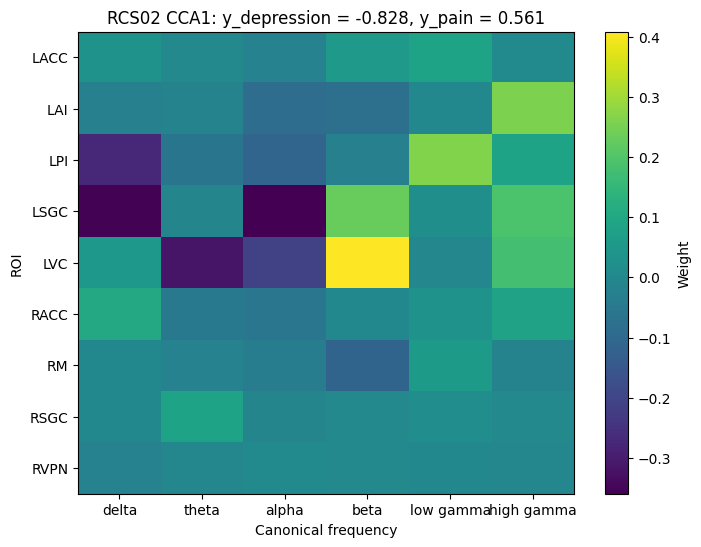

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
plt.imshow(cca.x_weights_[:,0].reshape(len(large_ROI), len(bands)), aspect='auto')
plt.colorbar(label='Weight')
x_ticks, y_ticks = np.arange(len(bands)), np.arange(len(large_ROI))
ax.set(xticks = x_ticks, xticklabels = bands, yticks = y_ticks, yticklabels = large_ROI)
plt.title(f"{ptID} CCA1: y_depression = {np.round(cca.y_weights_[0, 0],3)}, y_pain = {np.round(cca.y_weights_[1, 0],3)}")
ax.set_xlabel("Canonical frequency")
ax.set_ylabel("ROI")
plt.show()

In [54]:
corrs

array([0.84480323, 0.76756901])

In [ ]:
from fooof import FOOOF, FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fm, get_band_peak_fg

# Initialize FOOOF group object for each trial
fg = FOOOFGroup(peak_width_limits=[1, 8], min_peak_height=0.1, max_n_peaks=6)

# Define frequency range across which to model the spectrum
freq_range = [3, 40] # Min frequency suggested to be twice the lowest recorded frequency to filter out noise
new_freq = np.arange(1,130,130/40) # minf = 1, maxf = 130; all_data_nolog is recalculated based on new_freq and without log

fg.fit(new_freq, np.array(np.transpose(all_data_nolog[:,:,0])), freq_range) # new_freq and spectra data are required to be linearly spaced, spectra requires psd (no log)

# fg.save('FG_results', save_settings=True, save_results=True)

# Extract aperiodic parameters
aps = fg.get_params('aperiodic_params')

# Extract peak parameters
peaks = fg.get_params('peak_params')

# Extract goodness-of-fit metrics
errors = fg.get_params('error') # Need an error threshold?
r2s = fg.get_params('r_squared')

# Save raw data of periodic and aperiodic features
pdf = pd.DataFrame(peaks, columns=['CF','PW','BW','Channel']) # Num peaks of all group/channel * 4
pdf['Channel'] = pdf['Channel'].astype('int')
apdf = pd.DataFrame(aps, columns=['Offset','Exp']) # Num group/channel * 2
pdf.to_csv("dir")
apdf.to_csv("dir")